In [532]:
%pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from ipywidgets import interact
import ipywidgets as widgets

from scipy.stats import wilcoxon
from scipy.spatial.distance import cdist, pdist

from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
#import sklearn.cluster.hierarchical as hclust

import warnings
warnings.filterwarnings('ignore')

In [3]:
init_notebook_mode(connected=True)

In [178]:
import matplotlib.cm as cm
import matplotlib as matplotlib

def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color

In [5]:
class AlgorithmComparisonData():
    def __init__(self, wins, significant_wins, defeats, significant_defeats):
        self.wins = wins
        self.significant_wins = significant_wins
        self.defeats = defeats
        self.significant_defeats = significant_defeats

    def __str__(self):
        return f"wins: {self.wins}({self.significant_wins})\ndefeats: {self.defeats}({self.significant_defeats})"

class ExperimentsDataAnalyzer():

    def __init__(self):
        self.data_lake = {}

    def load_data(self, data_source_name, data_source_path):
        df = pd.read_csv(data_source_path, sep=';')
        self.data_lake[data_source_name] = df

    def get_data_frame(self, data_source_name):
        return self.data_lake[data_source_name].copy()

    def compare(self, ref_alg_datasource_name, target_alg_datasource_name):
        ref_df = self.get_data_frame(ref_alg_datasource_name)
        tgt_df = self.get_data_frame(target_alg_datasource_name)
        
        wins, swins = 0, 0 
        defeats, sdefeats = 0, 0
    
        for i in range(len(tgt_df)):
            data1 = ref_df.iloc[i][1:]
            data2 = tgt_df.iloc[i][1:]
            
            d1_mean = np.mean(data1)
            d2_mean = np.mean(data2) 
        
            is_signif = False
            if d1_mean == 0.0 and d2_mean == 0.0:
                is_signif = False
            else:
                stat, p = wilcoxon(data1, data2, zero_method="zsplit", )
                if p <= 0.05:
                    is_signif = True
            
            if d1_mean > d2_mean:
                wins += 1
                if is_signif:
                    swins += 1
        
            elif d1_mean < d2_mean:
                defeats += 1
                if is_signif:
                    sdefeats += 1

        return AlgorithmComparisonData(wins, swins, defeats, sdefeats)

In [4]:
def get_x1_results(base_path, target_config):
    analyzer = ExperimentsDataAnalyzer()
    
    alg_ref_ds_name = "lshade_costs_by_seed"
    alg_ref_path = f"{base_path}/out(--lshade ).csv"

    alg_target_ds_name = "dmlshade_costs_by_seed"
    alg_target_path = f"{base_path}/out({target_config} ).csv"

    analyzer.load_data(alg_ref_ds_name, alg_ref_path)
    analyzer.load_data(alg_target_ds_name, alg_target_path)

    results = analyzer.compare(alg_ref_ds_name, alg_target_ds_name)

    return results

In [5]:
base_path = "~/code/FIM-CGRASP/results/stats_test_data/uv=10"
print(get_x1_results(base_path, "--dmlshade --crossgen --insert --k 36 --elsz 47 --dms 26"))

wins: 12(8)
defeats: 12(2)


In [7]:
base_path = "~/code/FIM-CGRASP/results/stats_test_data"
with open("algconfigs") as alg_configs:
    for config in alg_configs:
        print("Config: ", config)
        print(get_x1_results(base_path, config.replace("\n", "")))
        print("----")

Config:  --fimlshade --crossgen --elsz 126 --dms 9 --h 36 --s 44

wins: 14(3)
defeats: 10(1)
----
Config:  --fimlshade --crossgen --elsz 54 --dms 61 --h 5 --s 21

wins: 10(0)
defeats: 13(0)
----
Config:  --fimlshade --crossgen --elsz 150 --dms 18 --h 13 --s 42

wins: 14(2)
defeats: 10(0)
----
Config:  --fimlshade --crossgen --elsz 152 --dms 18 --h 13 --s 42
wins: 18(0)
defeats: 6(0)
----


In [6]:
analyzer = ExperimentsDataAnalyzer()

func_number = 5
seed = 544
base_path = f"~/code/FIM-CGRASP/results/generations/LSHADE/cec-f{func_number}/s{seed}/"

analyzer.load_data("pop-costs", base_path + "pop-costs.csv")

gens_count = 2163
pop_generations = {}
for i in range(gens_count):
    df_id = f"pop-g{i+1}"
    analyzer.load_data(df_id, base_path + f"{df_id}.csv")

<Axes: >

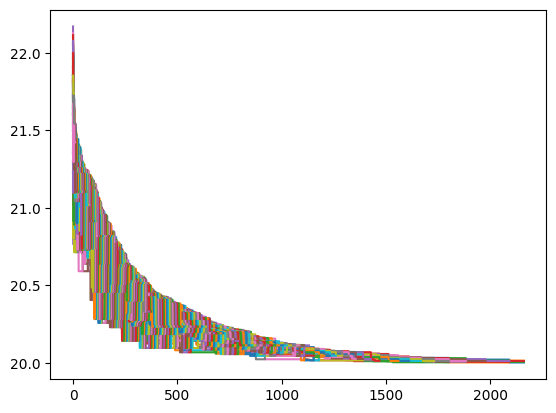

In [188]:
costs_df = analyzer.get_data_frame(f"pop-costs")
costs_df[costs_df != -1].plot(legend=False)

In [12]:
seeds = ['96', '194', '544', '555', '587']

<Axes: >

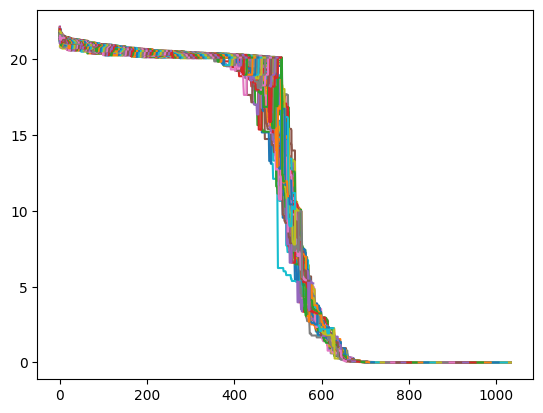

In [7]:
dm_analyzer = ExperimentsDataAnalyzer()

func_number = 5
seed = 544
base_path = f"~/code/FIM-CGRASP/results/generations/DM_LSHADE/cec-f{func_number}/s{seed}/"

dm_analyzer.load_data("pop-costs", base_path + "pop-costs.csv")

gens_count = 2163
pop_generations = {}
for i in range(gens_count):
    df_id = f"pop-g{i+1}"
    dm_analyzer.load_data(df_id, base_path + f"{df_id}.csv")

dm_costs_df = dm_analyzer.get_data_frame(f"pop-costs")
dm_costs_df[dm_costs_df != -1].plot(legend=False)


<Axes: >

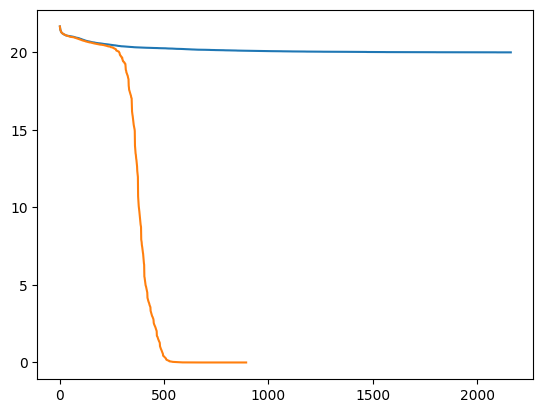

In [189]:
costs_df[costs_df != -1].mean(axis=1).plot()
dm_costs_df[dm_costs_df != -1].mean(axis=1).plot()

In [541]:
df = analyzer.get_data_frame(f"pop-g{1}")

fitness = costs_df[costs_df != -1].iloc[0]
fmin = 20
fmax = np.max(fitness)

In [542]:
sorted(fitness)[30]

21.4542

In [543]:
fitness.map(lambda x: "elite" if x < sorted(fitness)[30] else "common")

i1      common
i2       elite
i3      common
i4      common
i5      common
         ...  
i176    common
i177     elite
i178    common
i179    common
i180    common
Name: 0, Length: 180, dtype: object

In [7]:
def plot_pop_parallel_coordinates(gen_id):
    df = analyzer.get_data_frame(f"pop-g{gen_id}")
    
    fitness = costs_df[costs_df != -1].iloc[gen_id-1]
    #fmin = np.min(fitness)
    #fmax = np.max(fitness)

    colors = fitness.map(lambda x: color_map_color(x, cmap_name='bwr', vmin=fmin, vmax=fmax))
    elite = fitness.map(lambda x: "elite" if x < sorted(fitness)[30] else "common")

    df["class"] = range(1, len(df) + 1)
    pd.plotting.parallel_coordinates(df, 'class', color=colors)
    plt.gca().legend_.remove()

def plot_elite_parallel_coordinates(gen_id, elite_percent=0.3):
    df = analyzer.get_data_frame(f"pop-g{gen_id}")

    fitness = costs_df.iloc[gen_id-1]
    fitness = fitness[fitness > -1]

    elite = fitness[fitness != np.nan].map(lambda x: "elite" if x < sorted(fitness)[int(elite_percent * len(fitness))] else "common")

    df['class']  = list(elite)

    pd.plotting.parallel_coordinates(df[list(elite != 'common')], 'class', color=('blue', '#4ECDC4'))


def plot_pop_clusters_parallel_coordinates(gen_id,  k=4):
    df = dm_analyzer.get_data_frame(f"pop-g{gen_id}")

    #k=4
    model = KMeans(n_clusters=k).fit(df)

    df["class"] = model.labels_

    pd.plotting.parallel_coordinates(df, 'class', colormap='tab20')
    plt.gca().legend_.remove()


def plot_elite_clusters_parallel_coordinates(gen_id, k=4):
    df = dm_analyzer.get_data_frame(f"elite-g{gen_id}")

    
    model = KMeans(n_clusters=k).fit(df)

    df["class"] = model.labels_

    pd.plotting.parallel_coordinates(df, 'class', color=('red', 'green' , 'blue', 'black'))
    plt.gca().legend_.remove()

def plot_elite_principal_componentes(gen_id, k=3):
    df = dm_analyzer.get_data_frame(f"elite-g{gen_id}")

    model = KMeans(n_clusters=k).fit(df)
    df["labels"] = model.labels_
    print("Inertia:", model.inertia_)
    pca = PCA(n_components=2)
    
    PCs = pd.DataFrame(pca.fit_transform(df.drop(["labels"], axis=1)))

    PCs.columns = ["PC1", "PC2"]

    df = pd.concat([df,PCs,], axis=1, join='inner')

    sns.scatterplot(x=df["PC1"], y=df["PC2"], hue=df['labels'])
    

In [8]:
interact(plot_pop_clusters_parallel_coordinates, gen_id=widgets.IntSlider(min=1, max=gens_count, step=1, value=1))

interactive(children=(IntSlider(value=1, description='gen_id', max=2163, min=1), IntSlider(value=4, descriptio…

<function __main__.plot_pop_clusters_parallel_coordinates(gen_id, k=4)>

In [9]:
_gen_id_ = 500
df = analyzer.get_data_frame(f"pop-g{_gen_id_}")

inertia = []
K = range(1,len(df))
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    kmeanModel.fit(df)
    inertia.append(kmeanModel.inertia_)


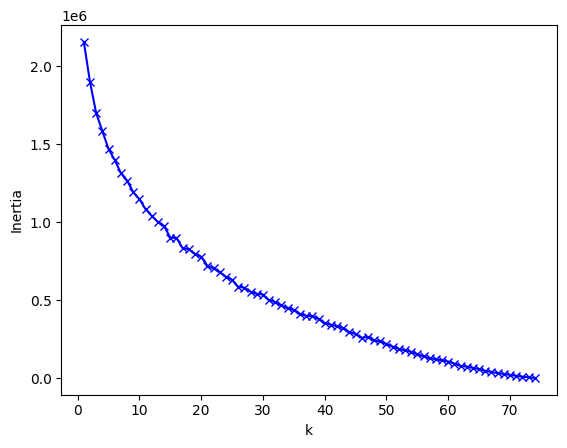

In [547]:
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [548]:
kmeans = KMeans(n_clusters=4).fit(df)

In [549]:
kmeans.labels_

array([2, 1, 2, 1, 0, 0, 0, 2, 2, 1, 0, 1, 1, 2, 2, 2, 3, 3, 1, 0, 3, 0,
       0, 3, 2, 1, 2, 2, 3, 0, 2, 0, 1, 3, 1, 0, 0, 1, 3, 2, 2, 2, 1, 2,
       3, 2, 2, 0, 3, 3, 0, 2, 3, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 1, 2, 3,
       1, 3, 0, 3, 1, 1, 0, 1, 3], dtype=int32)

### Analyze the elite data:

In [39]:
# Load elite data
# seeds: 1:544, 2:555, 3:194, 6:17, 10:217
seed=96
func_number = 5
gens_count = 2163
base_path = f"~/code/FIM-CGRASP/results/generations/LSHADE/cec-f{func_number}/s{seed}/"

pop_generations = {}
analyzer = ExperimentsDataAnalyzer()
for i in range(gens_count):
    df_id = f"elite-f{func_number}-s{seed}-g{i+1}"
    analyzer.load_data(df_id, base_path + f"elite-g{i+1}.csv")

In [62]:
interact(plot_elite_principal_componentes, gen_id=widgets.IntSlider(min=1, max=gens_count, step=1, value=1))

NameError: name 'plot_elite_principal_componentes' is not defined

In [63]:
interact(plot_elite_principal_componentes, gen_id=widgets.IntSlider(min=1, max=gens_count, step=1, value=1))

interactive(children=(IntSlider(value=1, description='gen_id', max=2163, min=1), IntSlider(value=3, descriptio…

<function __main__.plot_elite_principal_componentes(gen_id, k=3)>

In [ ]:
gen_id = 15
elite_df = analyzer.get_data_frame(f"elite-g{gen_id}")

In [97]:
interact(plot_elite_clusters_parallel_coordinates, gen_id=widgets.IntSlider(min=1, max=gens_count, step=1, value=1))

interactive(children=(IntSlider(value=1, description='gen_id', max=2163, min=1), IntSlider(value=4, descriptio…

<function __main__.plot_elite_clusters_parallel_coordinates(gen_id, k=4)>

In [64]:
gen_id = 1
elite_df = analyzer.get_data_frame(f"elite-g{gen_id}")

kmeans = KMeans(n_clusters=3).fit(elite_df)

labels = pd.DataFrame(kmeans.labels_) #This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeled_df = pd.concat((elite_df,labels),axis=1)
labeled_df = labeled_df.rename({0:'labels'},axis=1)

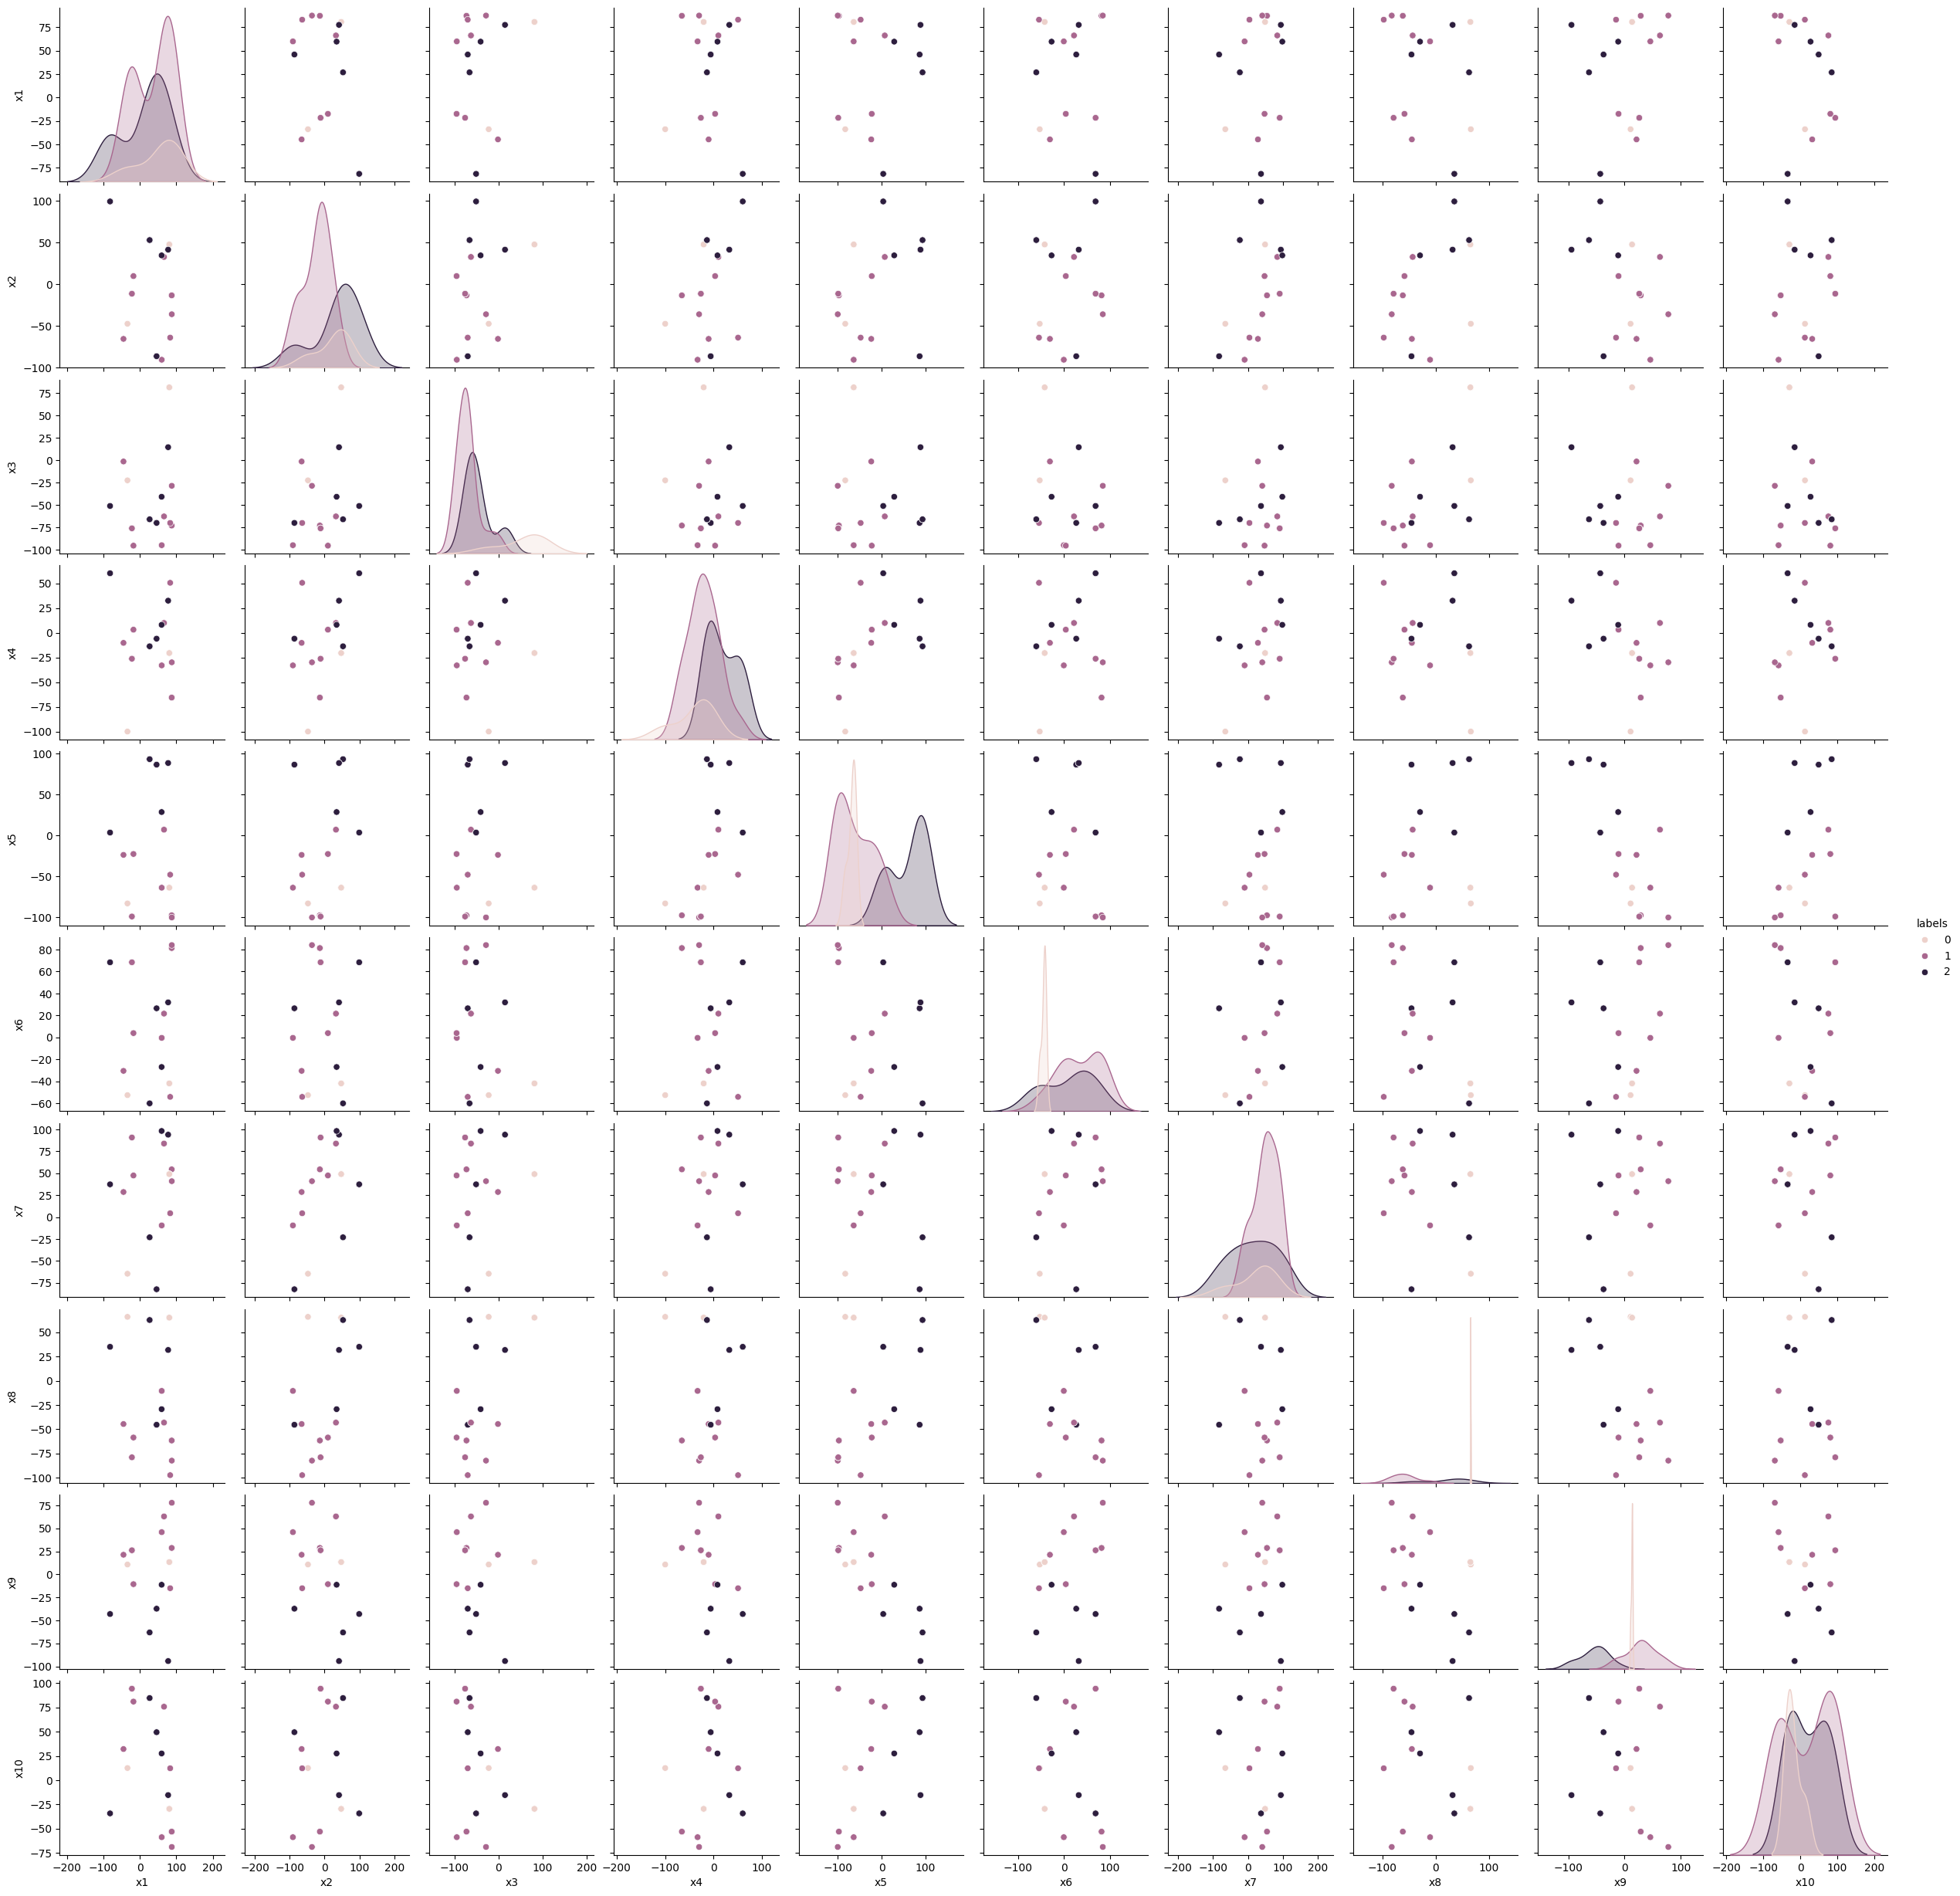

In [558]:
sns.pairplot(elite_df,hue='labels')

In [65]:
elite_df['Constant'] = "Data"

<Axes: xlabel='Constant', ylabel='x1'>

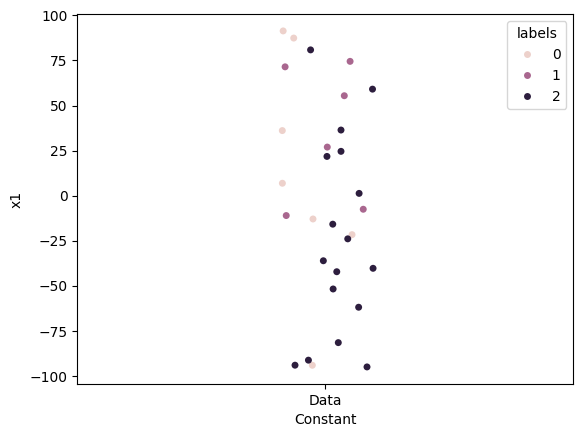

In [66]:
sns.stripplot(x=labeled_df['Constant'],y=labeled_df['x1'],hue=labeled_df['labels'],jitter=True)

<Axes: xlabel='Constant', ylabel='x7'>

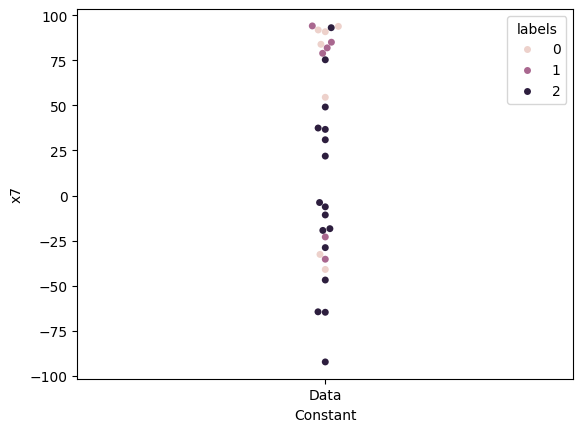

In [67]:
sns.swarmplot(x=labeled_df['Constant'],y=labeled_df['x7'],hue=elite_df['labels'])

In [198]:
#seed = 96
gen_id = 20

def plot_var_distribution(gen_id):
    #analyzer=dm_analyzer
    elite_df = analyzer.get_data_frame(f"elite-f{func_number}-s{seed}-g{gen_id}")

    # kmeans = KMeans(n_clusters=3).fit(elite_df)

    # labels = pd.DataFrame(kmeans.labels_) #This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
    # labeled_df = pd.concat((elite_df,labels),axis=1)
    # labeled_df = labeled_df.rename({0:'labels'},axis=1)

    elite_df['Constant'] = "Data"

    f, axes = plt.subplots(2, 5, figsize=(15, 10), sharex=False) #create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
    f.subplots_adjust(hspace=0.2, wspace=0.7) #Scooch em apart, give em some room

    for i in range(0,len(list(elite_df))-1):
        col = elite_df.columns[i]
        if i < 5:
            ax = sns.stripplot(x=elite_df['Constant'],y=elite_df[col].values,jitter=True,ax=axes[0,(i)])
            ax.set_title(col)
        elif i >= 5 and i<10:
            ax = sns.stripplot(x=elite_df['Constant'],y=elite_df[col].values,jitter=True,ax=axes[1,(i-5)]) #so if i=6 it is row 1 column 1
            ax.set_title(col)
        elif i >= 10 and i<15:
            ax = sns.stripplot(x=elite_df['Constant'],y=elite_df[col].values,jitter=True,ax=axes[2,(i-10)])
            ax.set_title(col)
        elif i >= 15:
            ax = sns.stripplot(x=elite_df['Constant'],y=elite_df[col].values,jitter=True,ax=axes[3,(i-15)])
            ax.set_title(col)

In [199]:
interact(plot_var_distribution, gen_id=widgets.IntSlider(min=1, max=gens_count, step=1, value=1))

interactive(children=(IntSlider(value=1, description='gen_id', max=2163, min=1), Output()), _dom_classes=('wid…

<function __main__.plot_var_distribution(gen_id)>

In [39]:
elite_df = analyzer.get_data_frame(f"elite-f{func_number}-s{seed}-g{gen_id}")

kmeans = KMeans(n_clusters=3).fit(elite_df)

labels = pd.DataFrame(kmeans.labels_) #This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeled_df = pd.concat((elite_df,labels),axis=1)
labeled_df = labeled_df.rename({0:'labels'},axis=1)


In [8]:
# Load elite data
# seeds: 1:544, 2:555, 3:194, 4:96, 5:587, 6:17, 7:758, 8:409, 9:624, 10:217
seed=544
func_number = 5
gens_count = 2163
base_path = f"~/code/FIM-CGRASP/results/generations/LSHADE/cec-f{func_number}/s{seed}/"

pop_generations = {}
analyzer = ExperimentsDataAnalyzer()
for i in range(gens_count):
    df_id = f"pop-f{func_number}-s{seed}-g{i+1}"
    analyzer.load_data(df_id, base_path + f"pop-g{i+1}.csv")

    df_id = f"elite-f{func_number}-s{seed}-g{i+1}"
    analyzer.load_data(df_id, base_path + f"elite-g{i+1}.csv")

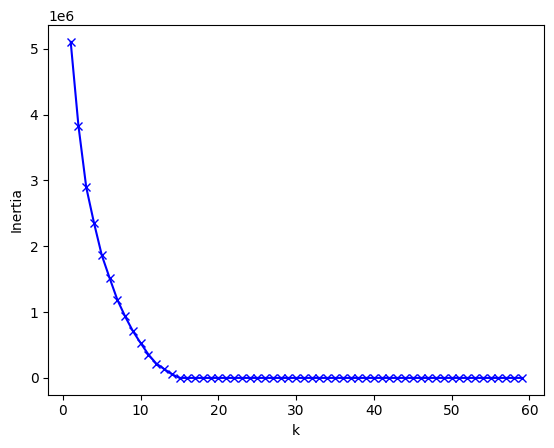

In [139]:
gen_id = 20
seed = 544
elite_df = analyzer.get_data_frame(f"elite-f{func_number}-s{seed}-g{gen_id}")

inertia = []
K = range(1,int(len(elite_df)/3))
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(elite_df)
    kmeanModel.fit(elite_df)
    inertia.append(kmeanModel.inertia_)
    

# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

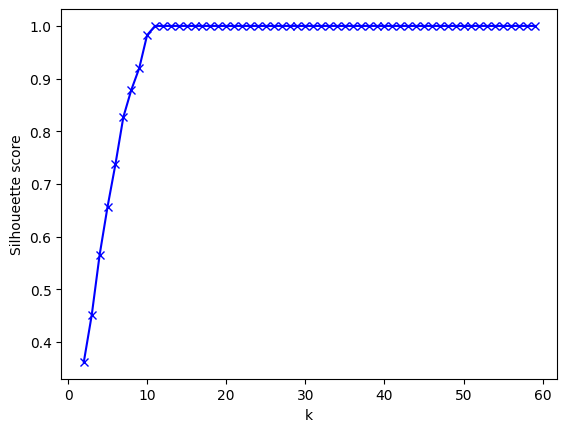

In [234]:
gen_id = 38
seed = 544
elite_df = analyzer.get_data_frame(f"elite-f{func_number}-s{seed}-g{gen_id}")

silhouette = []
K = range(2,int(len(elite_df)/3))
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(elite_df)
    kmeanModel.fit(elite_df)
    silhouette.append(silhouette_score(elite_df,  kmeanModel.labels_))
    

# Plot the elbow
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhoueette score')
plt.show()

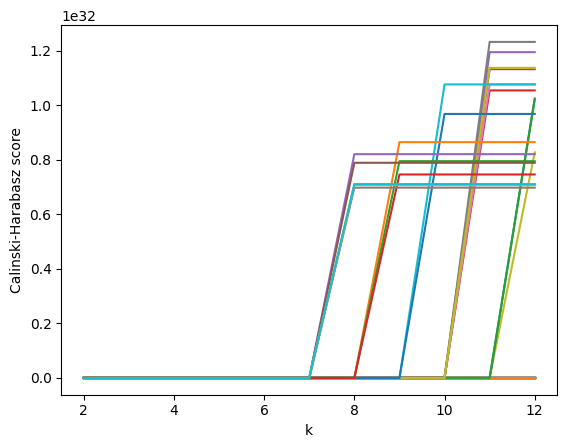

In [92]:
for gen_id in range(1, 51):
    if gen_id > 0:
        elite_df = analyzer.get_data_frame(f"elite-f{func_number}-s{seed}-g{gen_id}")

        metric = []
        K = range(2,int(np.sqrt(180)))
        for k in K:
            kmeanModel = KMeans(n_clusters=k).fit(elite_df)
            kmeanModel.fit(elite_df)
            metric.append(calinski_harabasz_score(elite_df,  kmeanModel.labels_))
            

        # Plot the elbow
        plt.plot(K, metric, label=f"{gen_id}")
    
plt.xlabel('k')
plt.ylabel('Calinski-Harabasz score')
#plt.legend()
plt.show()

In [215]:
max_metric

[3.5872970650161965e+31]

In [10]:
def plot_metric_history(metric_funciton, selector_function, max_gen):
    max_metric = []
    for gen_id in range(0, max_gen):
        
        if gen_id > 0:
            elite_df = analyzer.get_data_frame(f"elite-f{func_number}-s{seed}-g{gen_id}")

            metric = []
            K = range(2, int(np.sqrt(180)))
            for k in K:
                kmeanModel = KMeans(n_clusters=k).fit(elite_df)
                kmeanModel.fit(elite_df)
                if metric_funciton == "inertia":
                    metric.append(kmeanModel.inertia_)
                else:
                    metric.append(metric_funciton(elite_df,  kmeanModel.labels_))
            
            max_metric.append(selector_function(metric))

        # Plot the elbow
        plt.plot(range(0, len(max_metric)), max_metric, label=f"{gen_id}")


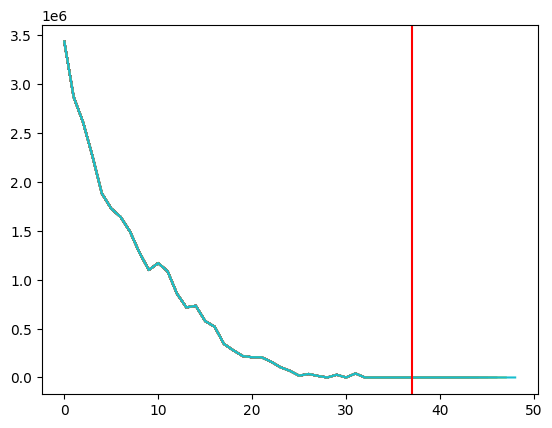

In [11]:
plot_metric_history("inertia", np.min, 50) 
plt.axvline(x = 37, color = 'r', label = 'axvline - full height')    

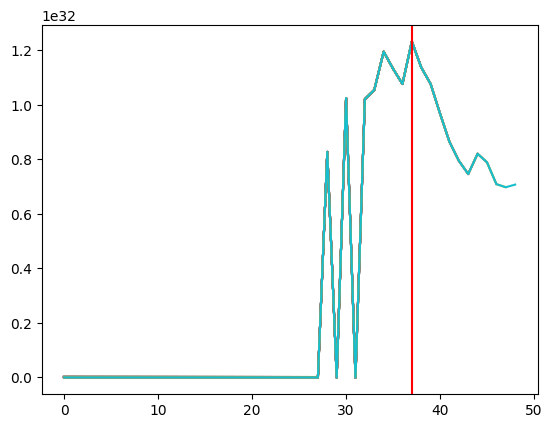

In [268]:
plot_metric_history(calinski_harabasz_score, np.max, 50) 
plt.axvline(x = 37, color = 'r', label = 'axvline - full height')      

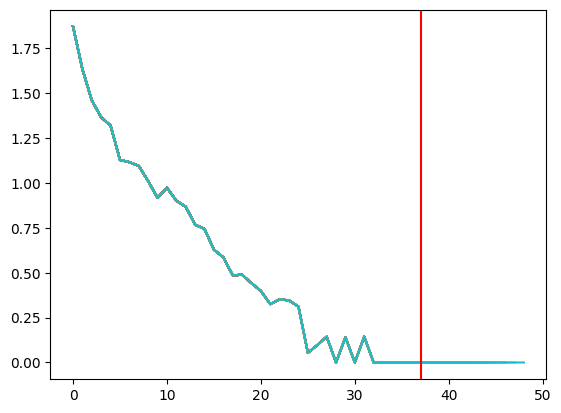

In [269]:
plot_metric_history(davies_bouldin_score, np.min, 50)  
plt.axvline(x = 37, color = 'r', label = 'axvline - full height')      

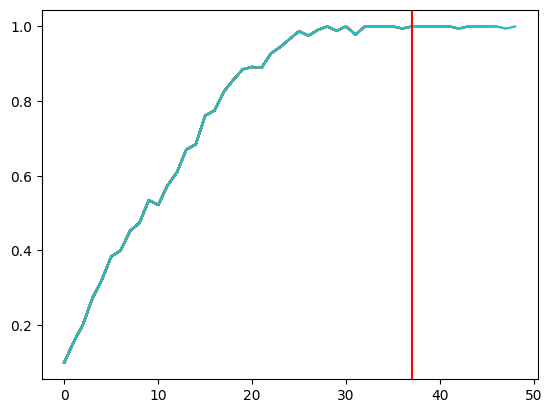

In [270]:
plot_metric_history(silhouette_score, np.max, 50) 
plt.axvline(x = 37, color = 'r', label = 'axvline - full height')      

In [141]:
def compute_pdist_diversity(gen_id):
    """
    Compute Pairwise distances between observations in n-dimensional space.
    """

    X = analyzer.get_data_frame(f"elite-f{func_number}-s{seed}-g{gen_id}")
    return np.mean(pdist(X))

def compute_variance_diversity(gen_id, ds_type="pop"):
    """
    Return the population diversity as its variance, and the relative diveristy in relation to the first generation

    References: 
        1. Polakova, Radka & Tvrdik, Josef & Bujok, Petr. (2019). Differential evolution with adaptive mechanism of population size according to current population diversity. 
            Swarm and Evolutionary Computation. 50. 10.1016/j.swevo.2019.03.014. 
        2. Zaharie, Daniela. (2002). Critical values for the control parameters of differential evolution algorithms.
            Critical Values for the Control Parameters of Differential Evolution Algorithmss. 2. 62-67. 
        3. Beyer, Hans-Georg. (2000). On the Dynamics of EAs without Selection. 
    """

    global D_0
    if not D_0:
        D_0, _ = compute_variance_diversity(1)

    X = analyzer.get_data_frame(f"{ds_type}-f{func_number}-s{seed}-g{gen_id}")

    x_ = np.mean(X, 0) # mean vector
    d = X - x_
    D = np.mean(np.sum(d * d, 1))
    RD = D / D_0 

    return D, RD

def compute_hyperv_diversity(gen_id, ds_type="pop"):
    """
    Compute similarity as the ratio of hyper-volume of boundbox of current population 
        to the hyper-volume of bounded search space (or the aproximate hyper-volume of boundbox of initial population)

    Reference:
    1. Meng, Zhenyu and Quanbin Zhang. “HPDE: A dynamic Hierarchical Population based Differential Evolution with novel diversity metric.” Engineering Applications of Artificial Intelligence (2023): n. pag.
    2. Valentín Osuna-Enciso, Erik Cuevas, Bernardo Morales Castañeda. "A diversity metric for population-based metaheuristic algorithms". Information Sciences
    """
    D = 10
    lb = -100
    ub = 100

    Vlim = np.log(1 + np.power(abs(ub - lb), D))

    X = analyzer.get_data_frame(f"{ds_type}-f{func_number}-s{seed}-g{gen_id}")

    Vpop = np.log(1 + np.prod(np.abs(np.max(X, 0) - np.min(X, 0))))

    return np.sqrt(Vpop/Vlim)

In [147]:
compute_hyperv_diversity(1000)

1.1117218123143806

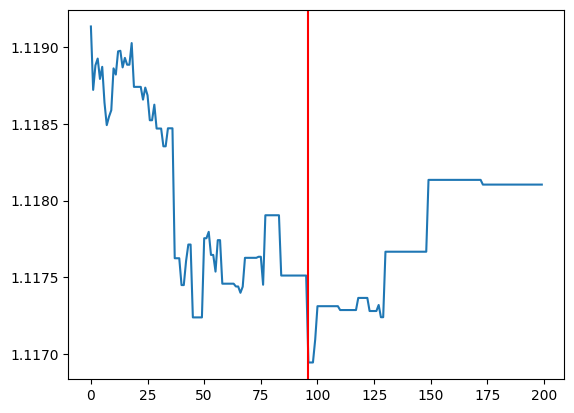

In [153]:
diversity = []
rdiversity = []
for g in range(200):
    d = compute_hyperv_diversity(g+1)
    diversity.append(d)
    
plt.plot(diversity)
plt.axvline(x = pd.Series(diversity).idxmin(), color = 'r', label = 'axvline - full height') 

In [138]:
np.prod(np.abs(np.max(X, 0) - np.min(X, 0)))

5.625372257529834e+21

In [95]:
def plot_diversity_history(max_gen):
    diversity = []
    for g in range(max_gen):
        diversity.append(compute_pdist_diversity(g + 1))

    plt.plot(diversity)

In [72]:
gen_id = 1
X = analyzer.get_data_frame(f"elite-f{func_number}-s{seed}-g{gen_id}")

x_ = np.mean(X, 0) # mean vector
a = X - x_
a2 = a * a

D_0 = np.mean(np.sum(a2, 1))

In [100]:
compute_variance_diversity(40)

(27222.307481814052, 0.8367092969263212)

In [101]:
compute_variance_diversity(40, "elite")

(20660.001356081648, 0.6350091821089069)

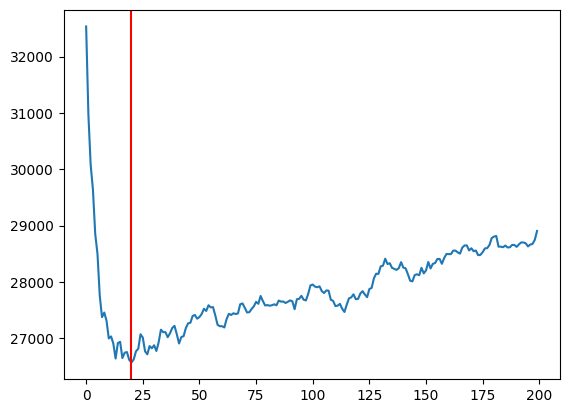

In [126]:
diversity = []
rdiversity = []
for g in range(200):
    d, rd = compute_variance_diversity(g+1)
    diversity.append(d)
    rdiversity.append(rd)
    
plt.plot(diversity)
plt.axvline(x = pd.Series(diversity).idxmin(), color = 'r', label = 'axvline - full height') 

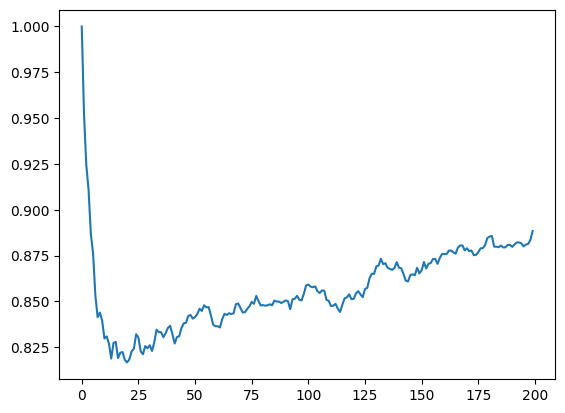

In [125]:
plt.plot(rdiversity)

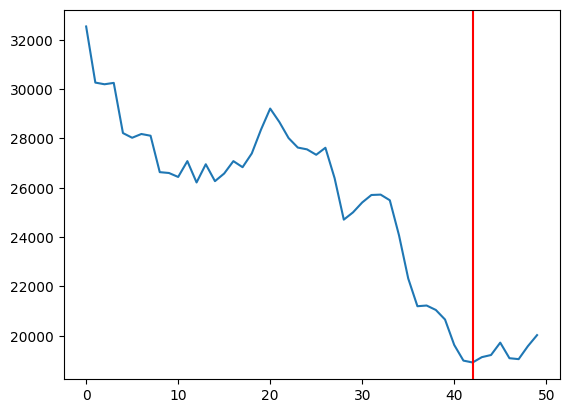

In [129]:
# Elite variance:
diversity = []
rdiversity = []
for g in range(50):
    d, rd = compute_variance_diversity(g+1, "elite")
    diversity.append(d)
    rdiversity.append(rd)
    
plt.plot(diversity)
plt.axvline(x = pd.Series(diversity).idxmin(), color = 'r', label = 'axvline - full height') 

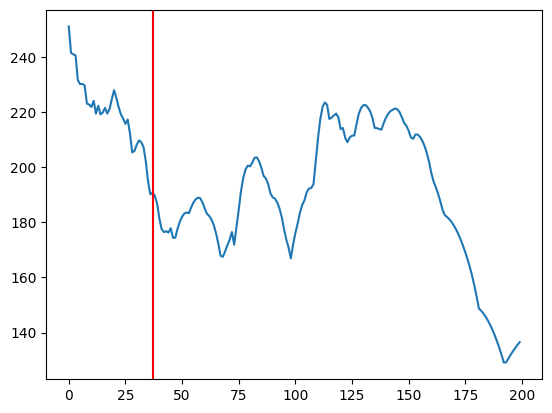

In [117]:
plot_diversity_history(200)
plt.axvline(x = 37, color = 'r', label = 'axvline - full height')      

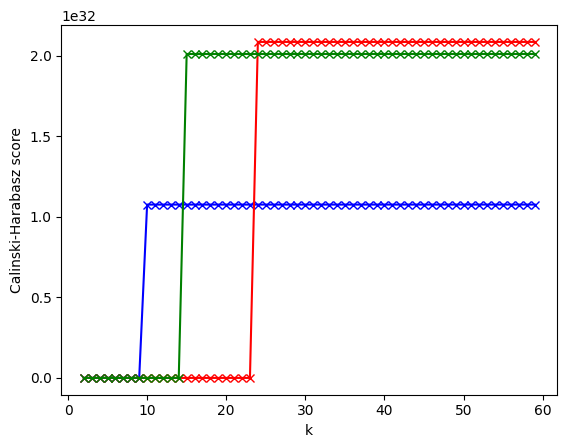

In [173]:
gen_id = 40
seed = 544
elite_df = analyzer.get_data_frame(f"elite-f{func_number}-s{seed}-g{gen_id}")

metric = []
K = range(2,int(len(elite_df)/3))
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(elite_df)
    kmeanModel.fit(elite_df)
    metric.append(calinski_harabasz_score(elite_df,  kmeanModel.labels_))

###

gen_id = 15
elite_df = analyzer.get_data_frame(f"elite-f{func_number}-s{seed}-g{gen_id}")

metric2 = []
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(elite_df)
    kmeanModel.fit(elite_df)
    metric2.append(calinski_harabasz_score(elite_df,  kmeanModel.labels_))

###

gen_id = 20 
elite_df = analyzer.get_data_frame(f"elite-f{func_number}-s{seed}-g{gen_id}")

metric3 = []
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(elite_df)
    kmeanModel.fit(elite_df)
    metric3.append(calinski_harabasz_score(elite_df,  kmeanModel.labels_))
    

# Plot the elbow
plt.plot(K, metric, 'bx-')
plt.plot(K, metric2, 'rx-')
plt.plot(K, metric3, 'gx-')
plt.xlabel('k')
plt.ylabel('Calinski-Harabasz score')
plt.show()

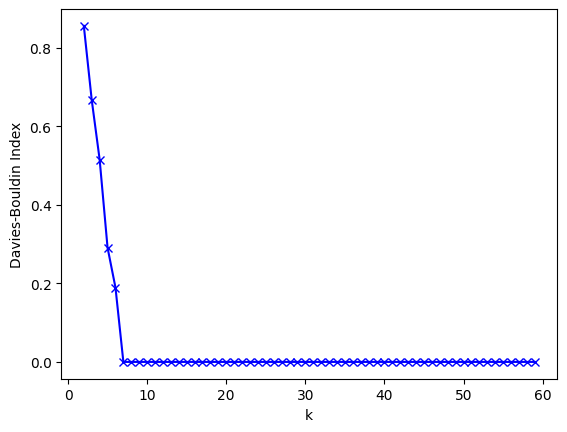

In [140]:
gen_id = 60
seed = 544
elite_df = analyzer.get_data_frame(f"elite-f{func_number}-s{seed}-g{gen_id}")

metric = []
K = range(2,int(len(elite_df)/3))
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(elite_df)
    kmeanModel.fit(elite_df)
    metric.append(davies_bouldin_score(elite_df,  kmeanModel.labels_))
    

# Plot the elbow
plt.plot(K, metric, 'bx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin Index')
plt.show()

In [117]:
kmeanModel = KMeans(n_clusters=10).fit(elite_df)
kmeanModel.fit(elite_df)
print(kmeanModel.inertia_)

silhouette_score(elite_df,  kmeanModel.labels_)

3.2186708224375113e-25


0.9999999959619733

In [201]:
def plot_pop_pcs(gen_id):
    elite_df = analyzer.get_data_frame(f"pop-f{func_number}-s{seed}-g{gen_id}")

    pca = PCA(n_components=2)
    PCs_2d = pd.DataFrame(pca.fit_transform(elite_df))
    PCs_2d.columns = ["PC1", "PC2"]
    plotX = pd.concat([elite_df,PCs_2d,], axis=1, join='inner')

    sns.scatterplot(x=plotX["PC1"], y=plotX["PC2"])

In [206]:
interact(plot_pop_pcs, gen_id=widgets.IntSlider(min=1, max=gens_count, step=1, value=1))

interactive(children=(IntSlider(value=1, description='gen_id', max=2163, min=1), Output()), _dom_classes=('wid…

<function __main__.plot_pop_pcs(gen_id)>

In [29]:
seed=544
func_number = 5
base_path = f"~/code/FIM-CGRASP/results/generations/LSHADE/cec-f{func_number}/s{seed}/"

gens_count = 2163
pop_generations = {}
for i in range(gens_count):
    df_id = f"pop-f{func_number}-s{seed}-g{i+1}"
    analyzer.load_data(df_id, base_path + f"elite-g{i+1}.csv")

In [16]:
seed=544
func_number = 5
base_path = f"~/code/FIM-CGRASP/results/generations/DM_LSHADE/cec-f{func_number}/s{seed}/"

gens_count = 2163
pop_generations = {}
for i in range(gens_count):
    df_id = f"elite-f{func_number}-s{seed}-g{i+1}"
    dm_analyzer.load_data(df_id, base_path + f"elite-g{i+1}.csv")

In [13]:
pca = PCA(n_components=2)
PCs_2d = pd.DataFrame(pca.fit_transform(labeled_df.drop(["labels"], axis=1)))
PCs_2d.columns = ["PC1", "PC2"]

In [572]:
plotX = pd.concat([labeled_df.drop(["Constant"], axis=1),PCs_2d,], axis=1, join='inner')

In [573]:
cluster0 = plotX[plotX["labels"] == 0]
cluster1 = plotX[plotX["labels"] == 1]
cluster2 = plotX[plotX["labels"] == 2]

In [577]:

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1"],
                    y = cluster0["PC2"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1"],
                    y = cluster1["PC2"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1"],
                    y = cluster2["PC2"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

<Axes: xlabel='PC1', ylabel='PC2'>

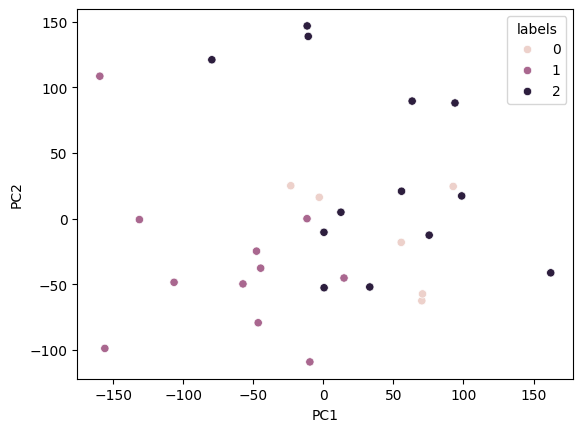

In [16]:
pca = PCA(n_components=2)
PCs_2d = pd.DataFrame(pca.fit_transform(labeled_df.drop(["labels"], axis=1)))
PCs_2d.columns = ["PC1", "PC2"]
plotX = pd.concat([labeled_df,PCs_2d,], axis=1, join='inner')

sns.scatterplot(x=plotX["PC1"], y=plotX["PC2"], hue=labeled_df['labels'])